## Derivation of propagation speed of a spike propagating through a 1D chain of excitatory neurons coupled to recurrent inhibition

### Overview
The aim is to solve exactly a simple network in which excitatory cells are coupled in a 1-D manner and a single inhibitory cell is recurrently coupled to all excitatory cells.

### Single cell model

Consider a 1-D chain of bursting neurons coupled to a single inhibitory cell. The governing equations for the dynamics of each individual cell are:

\begin{equation*}
\dot{V}(t) = -\frac{V(t)}{\tau_m} + \frac{I(t)}{C}
\label{eq:single_membrane} \tag{1}
\end{equation*}

where $V(t)$ is the membrane potential, $\tau_m$ is the membrane time constant, $I(t)$ is the external current, and $C$ is the membrane capacitance.

If neuron 1 is connected to neuron 2 by directional weight $w$, then the spike from 1 elicits current $I_{s}(t)$ in cell 2, where $I_{s}$ is given by:

\begin{equation*}
I_{s}(t) = w \frac{t}{\tau_{\alpha}} e^{-t/\tau_{\alpha}} \Theta (t)
\label{eq:single_spike_current} \tag{2}
\end{equation*}

where $\Theta$ is the Heaviside function.

### Constant current approximation

If neuron 1 fires at a consistent rate $f$, such that $1/f$ is proportional to or less the $\tau_{\alpha}$, the current in cell 2 will saturate at:

$$ I_{const} = w \tau_{\alpha} f $$

This is the constant current approximation. Further, the following equation is a reasonable approximation of the current as the cell is driven:

\begin{equation*}
I_{rise}(t) = w \tau_{\alpha} f \left(1 - e^{-t/\tau_{\alpha}}\right)
\label{eq:current_approx}
\end{equation*}

Therefore, a cell receiving $n$ spikes at frequency $f$ with the first spike occuring at $t=0$ will have the following current input:

\begin{equation*}
I(t) = \begin{cases} 
    w \tau_{\alpha} f \left(1 - e^{-t / \tau_{\alpha}}\right) & t \leq \frac{n}{f} \\
    w \tau_{\alpha} f \left(1 - e^{-n / (f \tau_{\alpha})}\right) e^{-(t - \frac{n}{f}) / \tau_{\alpha}} & t \gt \frac{n}{f} \\
\end{cases}
\label{eq:current_approx} \tag{3}
\end{equation*}

### Calculating number of output spikes

Typically, the excusion of the membrane potential due to an input current $I(t)$ is:

$$
V(t) = \frac{1}{C} \int_{0}^{t} I(t') e^{(t-t')/\tau_{m}} dt'
$$

until $V(t) = V_{th}$, at which point the voltage is reset.

For a first order solution, we take the membrane constant $\tau_m$ to be large compared to $t - t'$, allowing us to approximate $V(t)$ as:

$$
V(t) \approx \frac{1}{C} \int_{0}^{t} I(t') dt'
$$

The ouput spikes due to input current $I(t)$, then, is:

$$
n' = \frac{1}{C V_{th}} \int_0^{\inf} I(t') dt'
$$

Here, the integral is written with upper bound $\inf$, but it is understood the approximation only holds if $I(t)$ is non-zero for a duration comparable to $\tau_m$ or less.

The number of output spikes due to $n$ input spikes at frequency $f$ is then:

$$
n' = \frac{1}{C V_{th}} \int_0^{\inf} I(t') dt'
$$

$$
= \frac{w \tau_{\alpha} f}{C V_{th}} \left[\int_0^{n/f} \left(1 - e^{-t / \tau_{\alpha}}\right)dt + \int_{n/f}^{\inf} \left(1 - e^{-n / (f \tau_{\alpha})}\right) e^{-(t - \frac{n}{f}) / \tau_{\alpha}} dt \right]
$$

$$
= \frac{w \tau_{\alpha} f}{C V_{th}} \left[ \left(\frac{n}{f} + \tau_{\alpha} (e^{n/(f \tau_{\alpha})} - 1) \right) + \tau_{\alpha}\left(1 - e^{-n / (f \tau_{\alpha})}\right) \right]
$$

\begin{equation*}
n' = \frac{w \tau_{\alpha} n}{C V_{th}}
\label{eq:input_output_spike_relation} \tag{4}
\end{equation*}

This calculation, of course, is limited in that it does not calculate exactly when these spikes occur. For the time being, we will assume the spikes emitted from a drive cell always occur at frequency $f_0$.

### Considering a 1D chain without inhibition

From equation (4), we see that a chain without inhibition only supports one fixed points in its dynamics. This occurs when:

\begin{equation*}
\frac{w \tau_{\alpha}}{C V_{th}} = 1
\label{eq:input_output_spike_relation}
\end{equation*}

Otherwise, the number of spikes will continue to grow or decrease as the excitation propagates along the chain.

### Adding inhibition

We now consider an inhibitory cell that receives afferents from all excitatory cells organized in a 1D chain. The average spiking activity this cell receives is:

$$
f_{e->i} = \frac{n}{t^*},
$$

where $n$ is the number of spikes per excitatory cell and $t^*$ is the average latency in the first spike time of two adjacent neurons in the chain. 

Invoking the constant current approximation, the average current recieved is:

$$
I_{e->i} = w_{e->i} \tau_{\alpha} f_{e->i}
$$

$$
= \frac{w_{e->i} \tau_{\alpha} n}{t^*}
$$

To calculate the average firing rate of the I cell, we begin with the equation for the voltage of a current-coupled neuron driven by a constant current:

$$ V(t) = \frac{1}{C_i}\int_{0}^{t} e^{-(t-t')/\tau_m} I_{e->i} dt'$$

\begin{equation*}
V_{i}^{th} = \frac{I_{e->i}}{C_i} \tau_m \left(1 - e^{-t/\tau_m}\right)
\label{eq:steady_state_voltage} \tag{5}
\end{equation*}

This implies the average time to fire is:

$$ t^*_i = -\tau_m \log \left( 1 - \frac{V_{i}^{th} C_i}{I_{e->i} \tau_m} \right) $$

This implies firing rate $f_i$:

$$ f_i = \frac{-1}{\tau_m \log \left( 1 - \frac{V_{i}^{th} C_i t^*}{w_{e->i} \tau_{\alpha} n \tau_m} \right)} $$

This may be approximated effectively as:

\begin{equation*}
f_i = \begin{cases}
    0 & x \leq 1 \\
    \frac{1}{\tau_m log(2)} + \frac{1}{2 \tau_m log^2(2)} \left(x-2\right) & x \gt 1 \\
\end{cases}
\label{eq:current_approx} \tag{6}
\end{equation*}

where

$$
x = \frac{w_{e->i} \tau_{\alpha} n \tau_m}{V_{i}^{th} C_i t^*}.
$$

### Calculation of inter-layer first spike latency and spikes per layer

We assume a given excitatory cell in our 1D chain has been driven a long time by spiking activity from the inhibitory cell. Extrapolating from equation (5), the steady-state voltage of an excitatory cell will be:

$$
V_e = V_{e, 0} + \frac{I_{i->e} \tau_m}{C} = V_{e, 0} + \frac{w_{i->e} f_i \tau_{\alpha} \tau_m}{C}
$$

Here, it is assumed that $w_{i->e}$ is negative so that it lowers the steady-state voltage of the cell.

When an excitatory cell is driven by a spike train of $n$ spikes at frequency $f$, we can calculate the time to first spike of the driven cell (relative to the start of the incoming spike train) by examining the time-to-threshold of the driven cell:

\begin{equation*}
V(t^*) = V_{e}^{th} = V_{e, 0} + \frac{w_{i->e} f_i \tau_{\alpha} \tau_m}{C} + \frac{1}{C}  \int_0^{t^*} I_{e->e}(t') dt'
\label{eq:current_approx} \tag{7}
\end{equation*}

We now assume $t^* < \frac{n}{f}$, permitting us to use the first case of equation (3). We further set $V_{e, 0} = 0$. Equation (7) then becomes:

\begin{equation*}
V_{e}^{th} = \frac{w_{i->e} f_i \tau_{\alpha} \tau_m }{C} + \frac{w_{e->e} \tau_{\alpha} f}{C} \int_0^{t^*} (1 - e^{-t' / \tau_{\alpha}}) dt'
\label{eq:current_approx}
\end{equation*}

\begin{equation*}
V_{e}^{th} = \frac{w_{i->e} f_i \tau_{\alpha} \tau_m }{C} + \frac{w_{e->e} \tau_{\alpha} f}{C}  \left(t^* - \tau_{\alpha} (e^{-t^* / \tau_{\alpha}} - 1) \right)
\label{eq:current_approx}
\end{equation*}

\begin{equation*}
C V_{e}^{th} = w_{i->e} f_i \tau_{\alpha} \tau_m + w_{e->e} \tau_{\alpha} f  \left(t^* + \tau_{\alpha} - \tau_{\alpha} e^{-t^* / \tau_{\alpha}}) \right)
\label{eq:current_approx} \tag{8}
\end{equation*}

To calculate spikes per layer with inhibition present, we recall equation (4) and send $V_{th} \rightarrow V_{th} - \frac{w_{i->e} f_i \tau_{\alpha} \tau_m}{C} $, yielding:

\begin{equation*}
n' = \frac{w \tau_{\alpha} n}{C \left(V_{th} - \frac{w_{i->e} f_i \tau_{\alpha} \tau_m}{C} \right)}
\label{eq:input_output_spike_relation} \tag{9}
\end{equation*}

Recalling that $f_{i} = f_{i}(n, t^*)$, equations (6), (8), and (9) now fully determine $n'$ and $t^*$ for a given $n$. To make such a calculation tractable, we assume that $x > 1$ in (6) (the inhibitory cell will never fire if this is not true). Then the average current from the inhibitory cell into an excitatory cell is

\begin{equation*}
\tau_m f_i(n, t^*) = \left[ \frac{\log(2) - 1}{ \log^2(2)} +
\frac{1}{2 \log^2(2)} \left(\frac{w_{e->i} \tau_{\alpha} n \tau_m}{V_{i}^{th} C_i t^*}\right) \right]
\label{eq:current_approx} \tag{10}
\end{equation*}

Inserting into (8), we have:

\begin{equation*}
C V_{e}^{th} =
\frac{w_{i->e} \tau_{\alpha}}{ \log^2(2)} \left[\log(2) - 1 +
\frac{1}{2} \left(\frac{w_{e->i} \tau_{\alpha} n \tau_m}{V_{i}^{th} C_i t^*}\right) \right]
+ w_{e->e} \tau_{\alpha} f  \left(t^* + \tau_{\alpha} - \tau_{\alpha} e^{-t^* / \tau_{\alpha}}) \right)
\label{eq:current_approx} \tag{11}
\end{equation*}

This equation may be numerically solved to determine $t^*$.

Once $t^*$ has been calculated, $n'$ may be determined from equation (9).

## Equations for numerical calculatons

In [79]:
%matplotlib inline

from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import matplotlib
import numpy as np
from scipy import stats
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
from ntwk import LIFNtwkI
from aux import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import functools
from functools import partial
from matplotlib import cm

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [8]:
def map_to_list(func, l):
    '''
    Maps the list 'l' through the function 'func'
    Parameters
    ----------
    func : function
        Takes a single argument of type of 'l'
    l : list
    '''
    return list(map(func, l))

def reduce_mult(l):
    return functools.reduce(lambda e1, e2: e1 * e2, l, 1)

# multidimensional generalization of a cartesian proces
# given [2, 4, 6] and [2, 5, 8, 9] generates
# [[2, 2, 2, 2, 4, 4, 4, 4, 6, 6, 6, 6], [2, 5, 8, 9, 2, 5, 8, 9, 2, 5, 8, 9]]
def cartesian(*arrs):
    domain = map_to_list(lambda a: len(a), arrs)
    coordinate_lists = []
    for i, dim in enumerate(domain):
        coords = []
        mult = 1
        if i != len(domain) - 1:
            mult = reduce_mult(domain[i+1:])
        for e in arrs[i]:
            coords += (mult * [e])
        repeat_factor = reduce_mult(domain[0:i])
        if repeat_factor > 0:
            coords *= repeat_factor
        coordinate_lists.append(coords)
    return coordinate_lists

In [9]:
def calc_analytical_preds(w_e, w_r, params):
#     if w_e.shape != w_r.shape:
#         raise ValueError('Input matrices must have same shape')\\
    flattened_w_e = w_e.flatten()
    flattened_w_r = w_r.flatten()

    flattened_w_e_shape = flattened_w_e.shape[0]

    t_b = np.zeros(flattened_w_e_shape)
    t_1 = np.zeros(flattened_w_e_shape)
    t_2 = np.zeros(flattened_w_e_shape)
    f_i = np.zeros(flattened_w_e_shape)
    
    for i in range(flattened_w_e_shape):
        p = copy(params)
        p.update({
            'w_e': flattened_w_e[i],
            'w_r': flattened_w_r[i],
        })
        f = partial(calc_t_b, params=p)
        sol = fsolve(f, 1e-3)
        if len(sol) > 1:
            print(f'{len(sol)} solutions found')
        t_b[i] = sol[0]
        t_1[i] = calc_t_1(t_b[i], p)
        t_2[i] = t_1[i] + t_b[i]
        f_i[i] = p['w_r'] * t_b[i] / t_1[i]
    
    return t_b.reshape(w_e.shape), t_1.reshape(w_e.shape), t_2.reshape(w_e.shape), f_i.reshape(w_e.shape)

In [10]:
def make_graph(w_e_0, w_r_0, axs, color, t_b_setpoint=0.01):
#     axs[0].set_xlim(0, bound)
#     axs[0].set_ylim(0, bound)
    
#     axs[0].set_xlabel('N spikes in')
#     axs[0].set_ylabel('N spikes out')
    
#     axs[1].set_xlim(0, bound)
#     axs[1].set_ylim(0, 1)
    
#     axs[1].set_xlabel('N spikes in')
#     axs[1].set_ylabel('Propagation speed')

    base_params = {
        'tau': 3e-3,
        'v_0': 1,
    }
    
    w_e = np.array(w_e_0)
    w_r = np.array(w_r_0)

    w_r_hist = []
    w_e_hist = []
    t_b_hist = []
    t_1_hist = []
    f_i_hist = []
    
    l_iters = 1500

    for i in range(l_iters):
        t_b, t_1, t_2, f_i = calc_analytical_preds(w_e, w_r, base_params)
        
        w_r_hist.append(w_r)
        w_e_hist.append(w_e)
        t_b_hist.append(t_b)
        t_1_hist.append(t_1)
        f_i_hist.append(f_i)
        
        f_i_setpoint = 5
        w_e = w_e + 0.05 * w_e * ((t_b_setpoint - t_b) / t_b_setpoint) # 0.2 * np.exp(-t_1 / 0.02))
        w_r = w_r + 0.05 * w_e * ((f_i_setpoint - f_i) / f_i_setpoint)

    t = np.arange(l_iters)
    axs[0].plot(t, t_b_hist, lw=0.5, color=color, zorder=-1, label=f'w_e: {w_e_0}, w_r: {w_r_0}, t_b_set: {t_b_setpoint}')
    axs[1].plot(t, t_1_hist, lw=0.5, color=color, zorder=-1, label=f'w_e: {w_e_0}, w_r: {w_r_0}, t_b_set: {t_b_setpoint}')
    
    axs[2].plot(t, w_e_hist, lw=0.5, color=color, zorder=-1, label=f'w_e: {w_e_0}, w_r: {w_r_0}, t_b_set: {t_b_setpoint}')
    axs[3].plot(t, w_r_hist, lw=0.5, color=color, zorder=-1, label=f'w_e: {w_e_0}, w_r: {w_r_0}, t_b_set: {t_b_setpoint}')
    
    axs[4].plot(t, f_i_hist, lw=0.5, color=color)
    
    axs[0].set_ylabel('t_b')
    axs[1].set_ylabel('t_1')
    axs[2].set_ylabel('w_e')
    axs[3].set_ylabel('w_r')
    axs[4].set_ylabel('f_i')
        
    for i in range(5):
        axs[i].set_xlim(0, 1000)
        axs[i].legend()
        

<IPython.core.display.Javascript object>


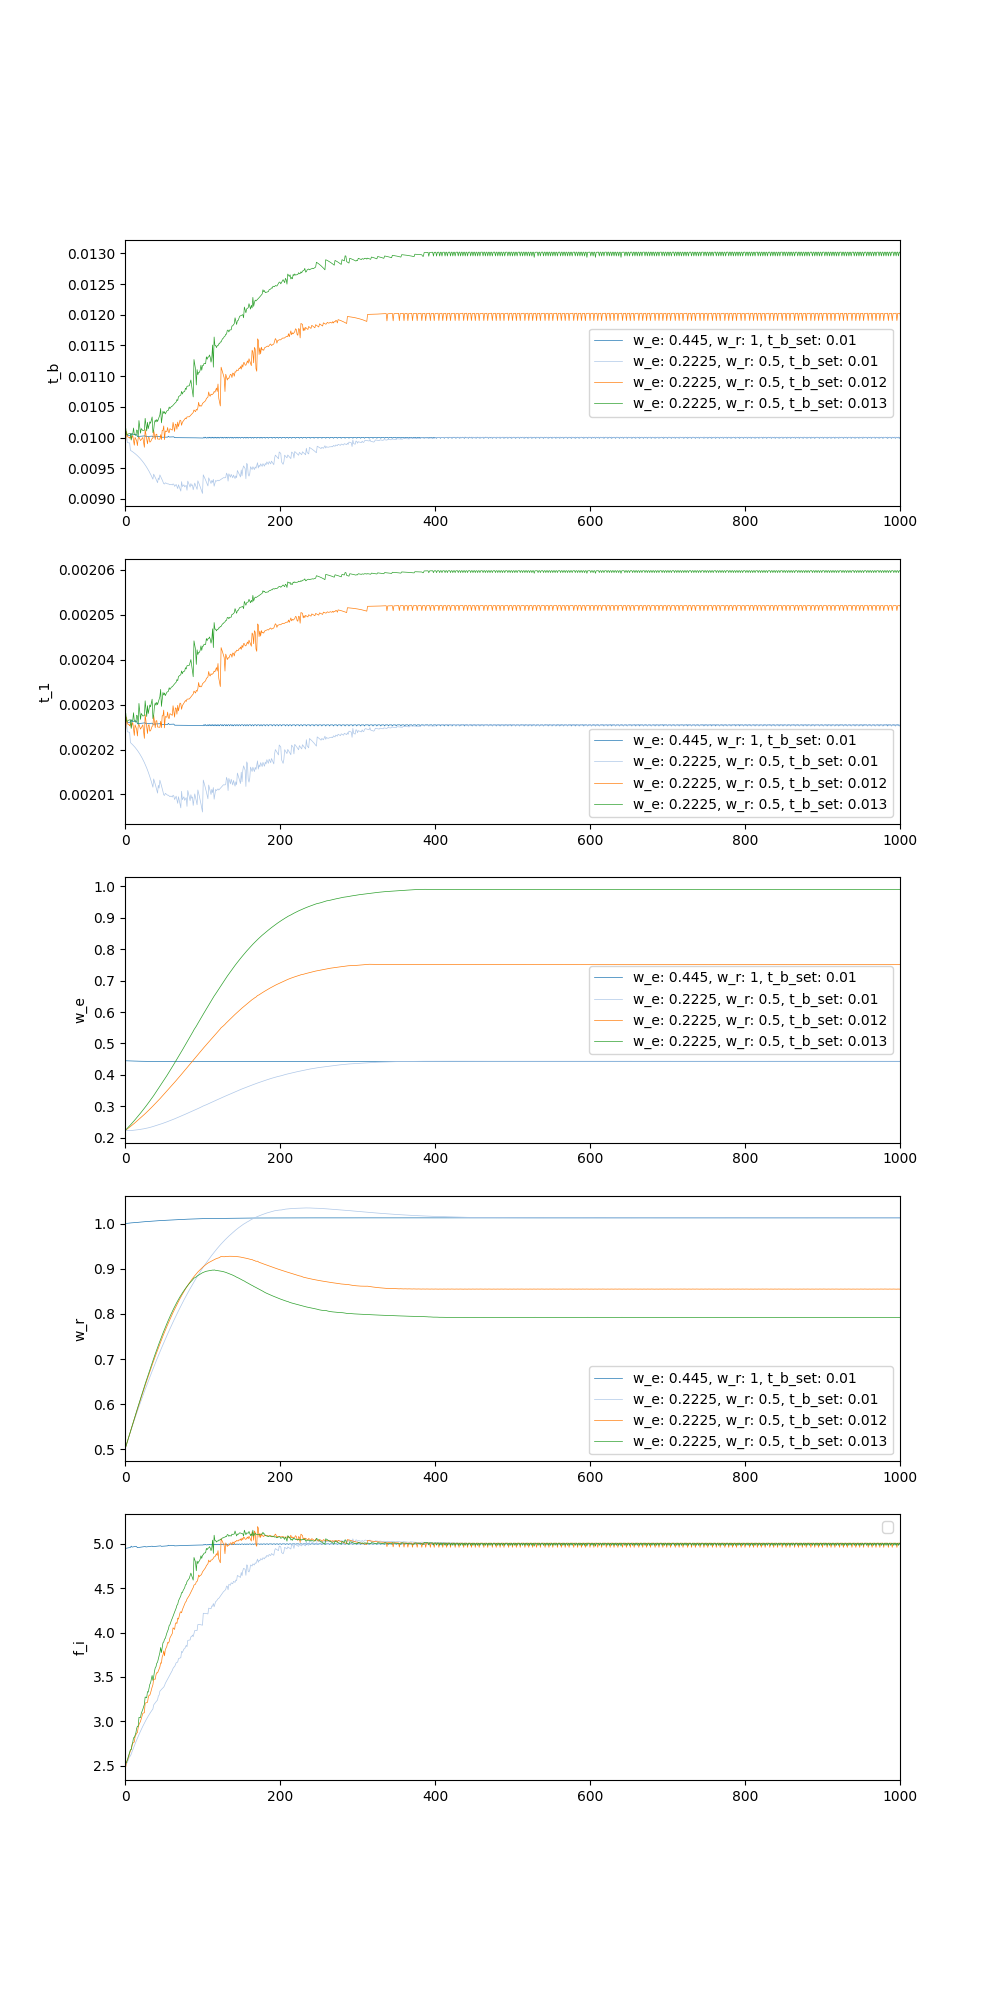

No handles with labels found to put in legend.


0.445 1
0.2225 0.5


No handles with labels found to put in legend.


0.2225 0.5


No handles with labels found to put in legend.


0.2225 0.5


No handles with labels found to put in legend.


In [55]:
w_e_vals = [0.445, 0.5 * 0.445, 0.5 * 0.445, 0.5 * 0.445]
w_r_vals = [1, 0.5, 0.5, 0.5] #np.arange(0.001, 1, 0.25)
t_b_setpoints=[0.01, 0.01, 0.012, 0.013]

scale = 1.
fig, axs = plt.subplots(5, 1, sharex=False, sharey=False, figsize=(10 * scale, 20 * scale))

def get_ordered_colors(cmap, n, lb=0, ub=1):
    cmap = cm.get_cmap(cmap)
    return cmap(np.linspace(lb, ub, n))

colors = get_ordered_colors('tab20', 16)
k=0
for i, (w_e, w_r, t_b_setpoint) in enumerate(zip(w_e_vals, w_r_vals, t_b_setpoints)):
    print(w_e, w_r)
    make_graph(w_e, w_r, axs, colors[k], t_b_setpoint=t_b_setpoint)
    k += 1

<IPython.core.display.Javascript object>


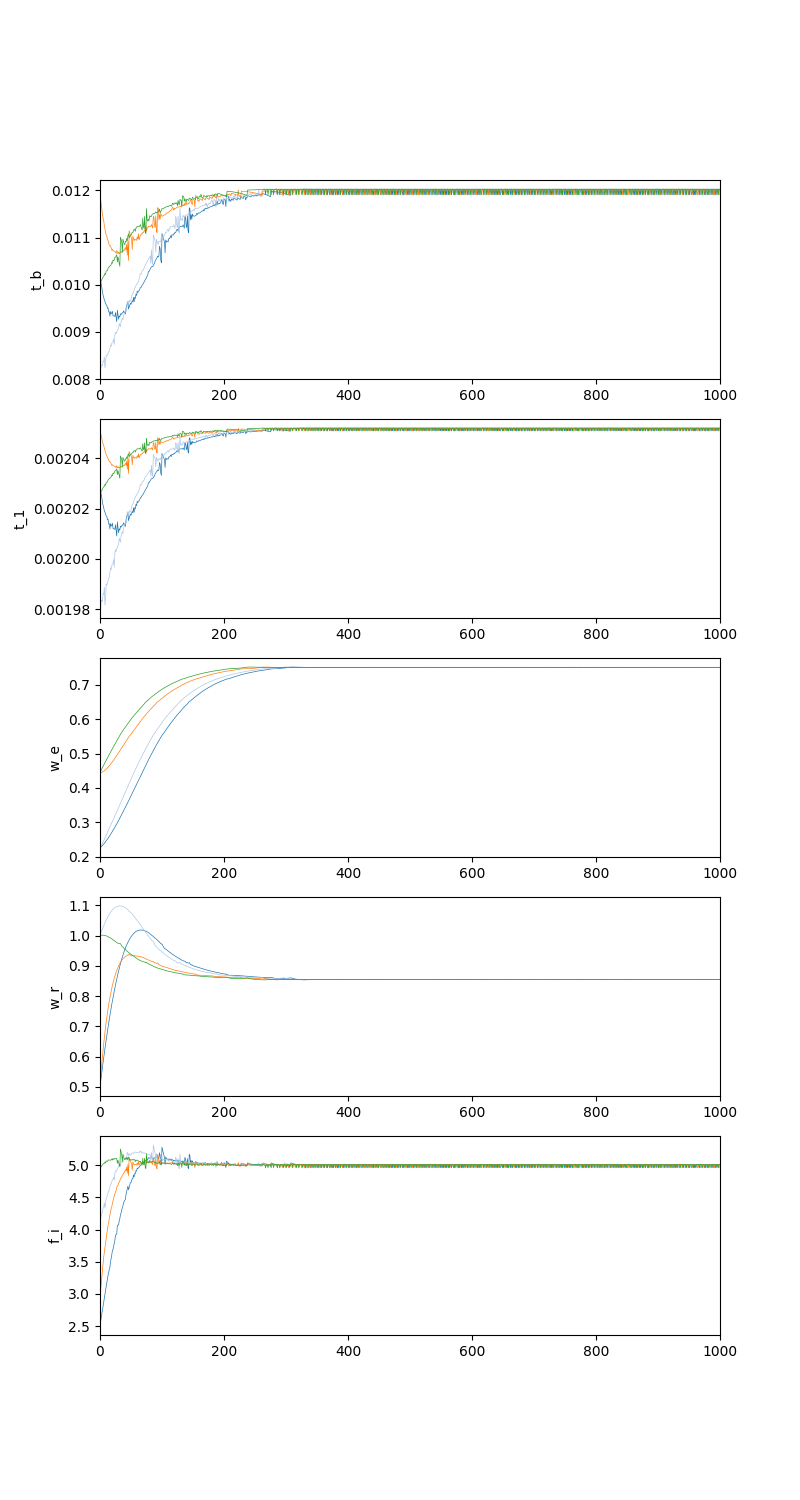

0.225 0.5
0.225 1
0.445 0.5
0.445 1


In [35]:
w_e_vals = [0.225, 0.445]
w_r_vals = [0.5, 1] #np.arange(0.001, 1, 0.25)

scale = 1.
fig, axs = plt.subplots(5, 1, sharex=False, sharey=False, figsize=(8 * scale, 15 * scale))

def get_ordered_colors(cmap, n, lb=0, ub=1):
    cmap = cm.get_cmap(cmap)
    return cmap(np.linspace(lb, ub, n))

colors = get_ordered_colors('tab20', 16)
for i, (w_e, w_r) in enumerate(zip(*cartesian(w_e_vals, w_r_vals))):
    print(w_e, w_r)
    make_graph(w_e, w_r, axs, colors[i], t_b_setpoint=0.012)

<IPython.core.display.Javascript object>


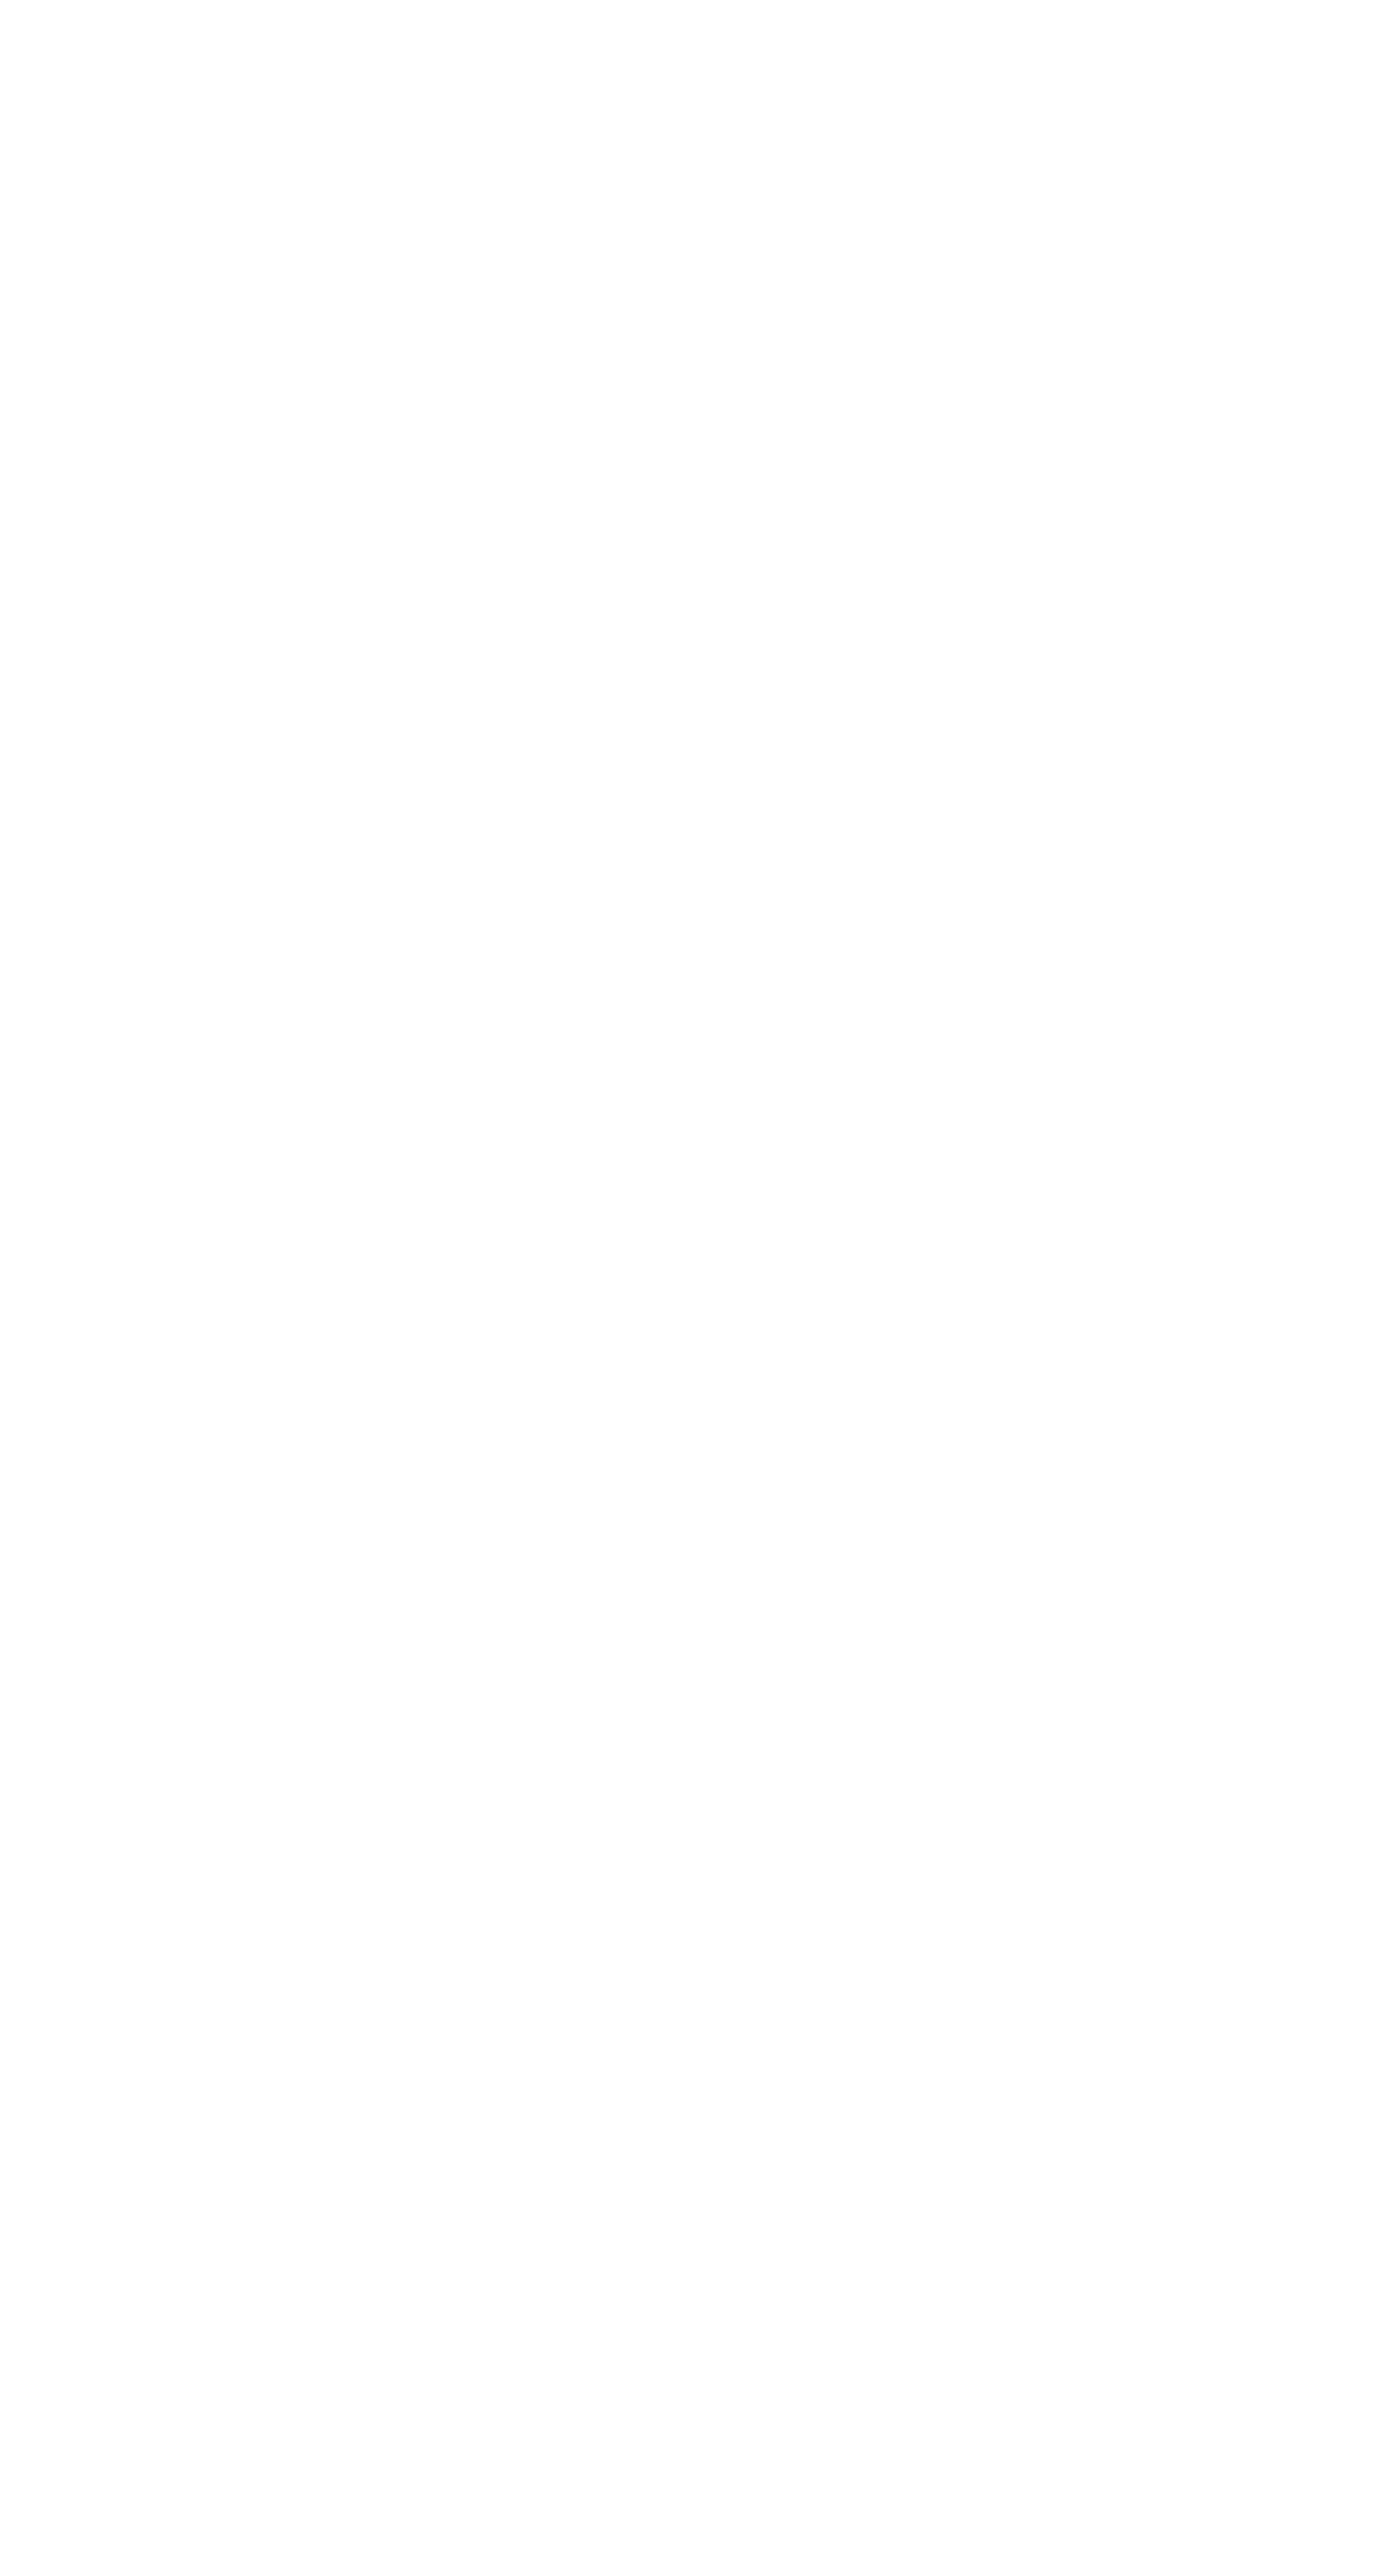

0.5 1


TypeError: calc_t_b() missing 2 required positional arguments: 't_d_in' and 't_d_out'

In [11]:
w_e_vals = [0.5, 1, 1.5]
w_r_vals = [1, 2] #np.arange(0.001, 1, 0.25)

scale = 1.
fig, axs = plt.subplots(5, 1, sharex=False, sharey=False, figsize=(8 * scale, 15 * scale))

def get_ordered_colors(cmap, n, lb=0, ub=1):
    cmap = cm.get_cmap(cmap)
    return cmap(np.linspace(lb, ub, n))

colors = get_ordered_colors('tab20', 16)
for i, (w_e, w_r) in enumerate(zip(*cartesian(w_e_vals, w_r_vals))):
    print(w_e, w_r)
    make_graph(w_e, w_r, axs, colors[i])

In [5]:
def map_dynamics(w_e_vals, w_r_vals):
    base_params = {
        'tau': 3e-3,
        'v_0': 1,
    }
    w_e, w_r = np.meshgrid(w_e_vals, w_r_vals)
    
    t_b, t_1, t_2, f_i = calc_analytical_preds(w_e, w_r, base_params)
    
    return w_e, w_r, t_b, t_1, t_2, f_i

In [6]:
w_e_vals = np.arange(0, 4, 0.05)
w_r_vals = np.arange(0.01, 16, 0.05)
w_e, w_r, t_b, t_1, t_2, f_i = map_dynamics(w_e_vals, w_r_vals)

NameError: name 'np' is not defined

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(w_e, w_r, t_b, 1000, cmap='binary')
ax.set_xlabel('w_e')
ax.set_ylabel('w_r')
ax.set_zlabel('t_b')

NameError: name 'plt' is not defined

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(w_e, w_r, t_1, 1000, cmap='binary')
ax.set_xlabel('w_e')
ax.set_ylabel('w_r')
ax.set_zlabel('t_1')

# ax.set_zlim(0.0018,0.0021)

### Calculation of stable values of p for different values of recurrent inhibition

In [6]:
dt = 5e-5
tau_m_e = 4e-3
tau_m_i = 4e-3
tau_a = 1.6e-3
v_th_e = 20e-3
v_th_i = 20e-3
c_e = 1e-6
c_i = 1e-6
f_e = 130

w_ee = 2.4e-4
w_ei = 0.5e-5
w_ie = -3e-5

In [7]:
# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.07,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=0.5e-3,  # refractory period (s)
    T_R_I=0,
    E_R_E=-0.07, # reset voltage (V)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    N_EXC=250,
    N_INH=1,
    
    # OTHER INPUTS
    SGM_N=0,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
    
    W_E_E = w_ee,
    W_E_I = w_ei, #0.2e-5, #1e-5,
    W_I_E = w_ie,
    W_U_E = 0,
    W_U_I = 0, #1e-1,
    
    F_IN = 500,
    SIGMA_IN = 10e-3,
    
    F_B = 5e3,
    T_B = 15e-3,
)

tau_m = 10e-3

t_r = M.T_R_E * np.ones((M.N_EXC + M.N_INH))
t_r[-1] = M.T_R_I

In [294]:
def calc_t_d(t_b_in, t_d_in, params):
    p = params
    return p['tau_e'] * np.log(1 / (1 - (p['v_th'] - p['tau_e'] * p['tau_i'] * p['w_r'] * t_b_in / t_d_in) / p['w_ee']))
    
def calc_t_b(t_b_in, t_d_in, t_d_out, params):
    p = params
    log_numerator = p['v_th'] - p['tau_e'] * p['tau_i'] * p['w_r'] * t_b_in / t_d_in
    log_denominator = p['w_ee'] * (1 - np.exp(-t_b_in / p['tau_e']))
    return p['tau_e'] * np.log(log_denominator / log_numerator) + t_b_in - t_d_out

def calc_out(t_b_in, t_d_in, params):
    p = params
    t_d_out = calc_t_d(t_b_in, t_d_in, p)
    t_b_out = calc_t_b(t_b_in, t_d_in, t_d_out, p)
    return t_b_out, t_d_out

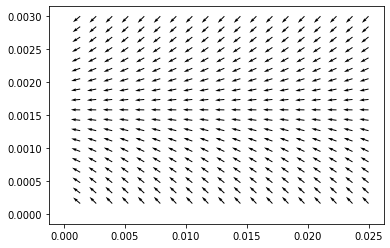

In [336]:
params = {
    'tau_e': 1e-3,
    'tau_i': 4e-3,
    'v_th': 0.04,
    'w_r': 0,
    'w_ee': 0.05,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 25e-3, 20), np.linspace(0, 3e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

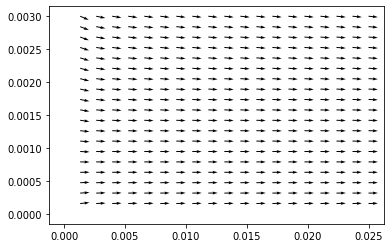

In [338]:
params = {
    'tau_e': 10e-3,
    'tau_i': 4e-3,
    'v_th': 0.04,
    'w_r': 0,
    'w_ee': 0.6,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 25e-3, 20), np.linspace(0, 3e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

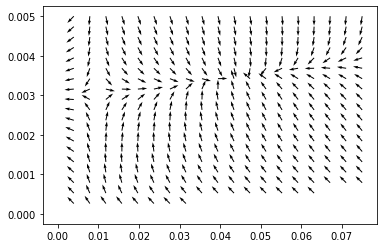

(0.04328234198209288, 0.0034653008895914744)

In [337]:
params = {
    'tau_e': 5e-3,
    'tau_i': 4e-3,
    'v_th': 0.04,
    'w_r': -20,
    'w_ee': 0.09,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 75e-3, 20), np.linspace(0, 5e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

solve_attractor_wrapper(params)

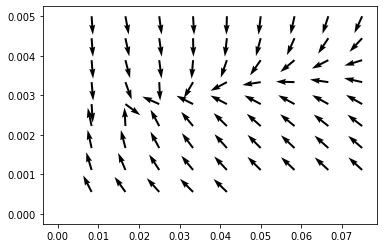

(0.021079513641759678, 0.002762286995884211)

In [298]:
params = {
    'tau_e': 4e-3,
    'tau_i': 4e-3,
    'v_th': 0.04,
    'w_r': -40,
    'w_ee': 0.09,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 75e-3, 10), np.linspace(0, 5e-3, 10))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

solve_attractor_wrapper(params)

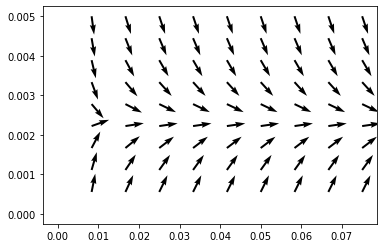

0.02 0.002759090077163839 362.43833004101606


In [299]:
params = {
    'tau_e': 4e-3,
    'tau_i': 4e-3,
    'v_th': 0.04,
    'w_r': 0,
    'w_ee': 0.09,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 75e-3, 10), np.linspace(0, 5e-3, 10))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

t_b_stable, t_d_stable = solve_attractor_wrapper(params)
print(t_b_stable, t_d_stable, 1/t_d_stable)

In [300]:
def fixed_t_d_from_t_b(t_b, params):
    p = params
    return p['tau_e'] * np.log(2 - np.exp(-t_b / p['tau_e']))

def solve_attractor(t_b, params):
    p = params
    exp_t_b = np.exp(-t_b / p['tau_e'])
    return (p['v_th'] - p['w_ee'] * ((1 - exp_t_b) / (2 - exp_t_b))) * fixed_t_d_from_t_b(t_b, p) - p['tau_e'] * p['tau_i'] * p['w_r'] * t_b

In [343]:
def solve_attractor_wrapper(params, guess=20e-3):
    p = params
    f = partial(solve_attractor, params=p)
    sol = fsolve(f, guess, maxfev=10000)
    if len(sol) > 1:
        print(f'{len(sol)} solutions found')
    t_b = sol[0]
    t_d = fixed_t_d_from_t_b(t_b, p)
    return t_b, t_d

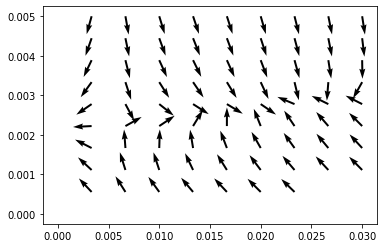

0.021323315065177085 0.00276289687608502 361.93895206721714


In [302]:
params = {
    'tau_e': 4e-3,
    'tau_i': 4e-3,
    'v_th': 0.03,
    'w_r': -60,
    'w_ee': 0.075,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 30e-3, 10), np.linspace(0, 5e-3, 10))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

t_b_stable, t_d_stable = solve_attractor_wrapper(params)
print(t_b_stable, t_d_stable, 1/t_d_stable)

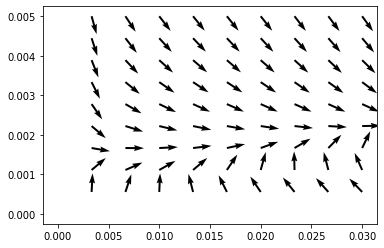

0.05776220409917997 0.0027725876517601007 360.67389947624474


In [303]:
params = {
    'tau_e': 4e-3,
    'tau_i': 4e-3,
    'v_th': 0.03,
    'w_r': -60,
    'w_ee': 0.10,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 30e-3, 10), np.linspace(0, 5e-3, 10))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

t_b_stable, t_d_stable = solve_attractor_wrapper(params)
print(t_b_stable, t_d_stable, 1/t_d_stable)

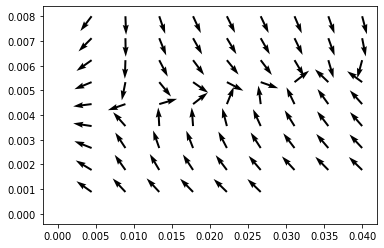

0.03316669008917362 0.0054816047503120705 182.4283299417145


In [304]:
params = {
    'tau_e': 8e-3,
    'tau_i': 4e-3,
    'v_th': 0.03,
    'w_r': -50,
    'w_ee': 0.08,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 40e-3, 10), np.linspace(0, 8e-3, 10))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

t_b_stable, t_d_stable = solve_attractor_wrapper(params)
print(t_b_stable, t_d_stable, 1/t_d_stable)

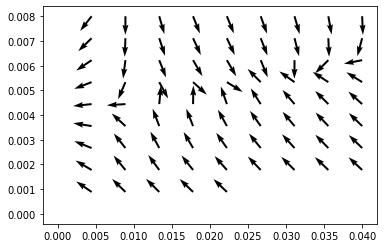

0.02575005587698684 0.005383536382273978 185.7515077436154


In [305]:
params = {
    'tau_e': 8e-3,
    'tau_i': 4e-3,
    'v_th': 0.03,
    'w_r': -60,
    'w_ee': 0.08,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 40e-3, 10), np.linspace(0, 8e-3, 10))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

t_b_stable, t_d_stable = solve_attractor_wrapper(params)
print(t_b_stable, t_d_stable, 1/t_d_stable)

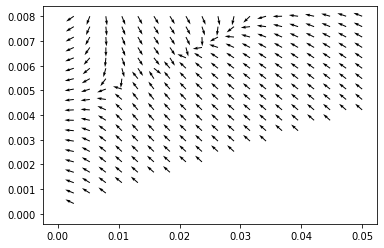

0.017873239546960178 0.00605731597709527 165.0896211756714


In [316]:
params = {
    'tau_e': 10e-3,
    'tau_i': 4e-3,
    'v_th': 0.03,
    'w_r': -150,
    'w_ee': 0.105,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 50e-3, 20), np.linspace(0, 8e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

t_b_stable, t_d_stable = solve_attractor_wrapper(params)
print(t_b_stable, t_d_stable, 1/t_d_stable)

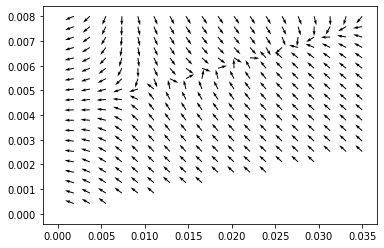

0.023467276738435277 0.006441240692561319 155.2495936310612


In [330]:
params = {
    'tau_e': 10e-3,
    'tau_i': 4e-3,
    'v_th': 0.015,
    'w_r': -60,
    'w_ee': 0.05,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 35e-3, 20), np.linspace(0, 8e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

t_b_stable, t_d_stable = solve_attractor_wrapper(params)
print(t_b_stable, t_d_stable, 1/t_d_stable)

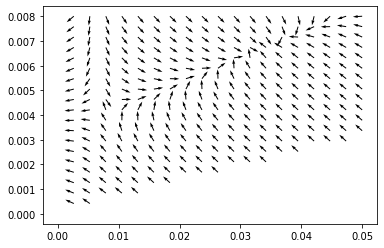

0.033884490494489466 0.00676122582009784 147.90217434055904


In [339]:
params = {
    'tau_e': 10e-3,
    'tau_i': 4e-3,
    'v_th': 0.015,
    'w_r': -60,
    'w_ee': 0.055,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 50e-3, 20), np.linspace(0, 8e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

t_b_stable, t_d_stable = solve_attractor_wrapper(params)
print(t_b_stable, t_d_stable, 1/t_d_stable)

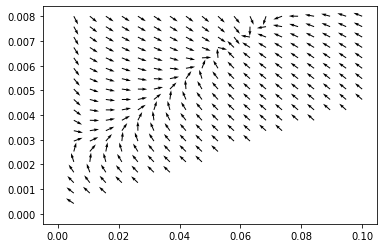

0.05746784824688097 0.0069154938953986615 144.60283171753886


In [345]:
params = {
    'tau_e': 10e-3,
    'tau_i': 4e-3,
    'v_th': 0.015,
    'w_r': -60,
    'w_ee': 0.07,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 100e-3, 20), np.linspace(0, 8e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.show()

t_b_stable, t_d_stable = solve_attractor_wrapper(params, guess=30e-3)
print(t_b_stable, t_d_stable, 1/t_d_stable)